In [1]:
## import library 
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from utilities import *
import pandas as pd
import seaborn as sns
import scanpy as sc 

def convert_string_to_float(s):
    s_without_commas = s.replace(',', '')
    return float(s_without_commas)

sns.set_style('whitegrid')

### News - Price Modelling

**Hypothesis:** 

1) News content could have effect on prices in the following day, 

2) **but the market still need several days to response**. 

#### Lithium Price 

Day-1, Day-2, Day-3, Day-6, Day-9, Day-12

#### News Data Set Engineering: 

1) Vectorize the text data

2) Create vocabulary to each article, vectorized using TD-IDF. 

4) Create vocabulary to each day, vectorized using TD-IDF. 

**Using the vectors as features to build model (Random Forest, Linear Regression and etc.)**

## Lithium Close Price: 

In [3]:
price = pd.read_excel("Data/lithium_price.xlsx")
price.Date = price.Date.apply(transform_date_price)
price[["Open", "High", "Low","Close"]] = price[["Open", "High", "Low","Close"]].applymap(convert_string_to_float)
price.columns = ['date', 'open', 'high','low','close','change','volume']
price.head()

,date,open,high,low,close,change,volume
0,2023-05-22,227500.0,230000.0,225000.0,227500.0,0.00,0
1,2023-05-19,227500.0,230000.0,225000.0,227500.0,0.00,0
2,2023-05-18,227500.0,230000.0,225000.0,227500.0,0.00,0
3,2023-05-16,227500.0,230000.0,225000.0,227500.0,9.64,0
4,2023-05-15,207500.0,210000.0,205000.0,207500.0,2.47,0


In [4]:
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1496 entries, 0 to 1495
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    1496 non-null   object 
 1   open    1496 non-null   float64
 2   high    1496 non-null   float64
 3   low     1496 non-null   float64
 4   close   1496 non-null   float64
 5   change  1496 non-null   float64
 6   volume  1496 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 81.9+ KB


In [5]:
price.describe()

,open,high,low,close,change,volume
count,1496.000000,1.496000e+03,1496.000000,1496.00000,1496.000000,1496.0
mean,176102.774064,1.883190e+05,174262.867647,176106.11631,0.042807,0.0
std,160633.071635,2.962744e+05,160111.054299,160633.04864,1.317982,0.0
min,39000.000000,3.900000e+04,39000.000000,39000.00000,-10.580000,0.0
25%,65500.000000,6.650000e+04,64500.000000,65500.00000,0.000000,0.0
50%,97000.000000,9.950000e+04,94000.000000,97000.00000,0.000000,0.0
75%,192500.000000,1.950000e+05,190000.000000,192500.00000,0.000000,0.0
max,597500.000000,5.750000e+06,595000.000000,597500.00000,20.570000,0.0


In [6]:
price.date.describe()

count           1496
unique          1496
top       2023-05-22
freq               1
Name: date, dtype: object

In [7]:
price_close = pd.DataFrame(price.close)
price_close.index = price.date

In [8]:
price_close.sort_index(inplace = True, ascending = False)

In [9]:
price_close.tail()

,close
date,
2017-05-16,136000.0
2017-05-15,136000.0
2017-05-12,136000.0
2017-05-11,136000.0
2017-05-10,136000.0


In [10]:
price_close.head()

,close
date,
2023-05-22,227500.0
2023-05-19,227500.0
2023-05-18,227500.0
2023-05-16,227500.0
2023-05-15,207500.0


#### Close Price Engineering: 

1. Group the news by the date, and normalize the words 
2. Create Day-1, Day-2, Day-3, Day-6, Day-9, Day-12 value for each day. 

In [11]:
outlier_cutoff = 0.01
data_eng = pd.DataFrame()
lags = [1, 2, 3, 6, 9, 12]
for lag in lags:
    data_eng [f'return_{lag}d'] = -(price_close
                           .pct_change(lag)
                           .stack()
                           .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                  upper=x.quantile(1-outlier_cutoff)))
                           .add(1)
                           .pow(1/lag)
                           .sub(1)
                           )
data_eng  = data_eng.swaplevel().dropna()
data_eng .info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1484 entries, ('close', '2023-05-03') to ('close', '2017-05-10')
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   return_1d   1484 non-null   float64
 1   return_2d   1484 non-null   float64
 2   return_3d   1484 non-null   float64
 3   return_6d   1484 non-null   float64
 4   return_9d   1484 non-null   float64
 5   return_12d  1484 non-null   float64
dtypes: float64(6)
memory usage: 118.1+ KB


In [12]:
data_eng

return_1d  return_2d  return_3d  return_6d  return_9d  \
      date                                                                
close 2023-05-03  -0.000000  -0.000000   0.026679   0.021722   0.020897   
      2023-05-02  -0.000000  -0.000000  -0.000000   0.017637   0.017202   
      2023-04-30   0.028169   0.014185   0.009479   0.022304   0.017658   
      2023-04-28  -0.000000   0.014185   0.009479   0.018117   0.017658   
      2023-04-27   0.032592   0.020500   0.023063   0.011599   0.019449   
...                     ...        ...        ...        ...        ...   
      2017-05-16  -0.000000  -0.000000   0.011963   0.005999   0.004004   
      2017-05-15  -0.000000  -0.000000  -0.000000   0.005999   0.004004   
      2017-05-12  -0.000000  -0.000000  -0.000000   0.005999   0.004004   
      2017-05-11  -0.000000  -0.000000  -0.000000   0.005999   0.004004   
      2017-05-10  -0.000000  -0.000000  -0.000000  -0.000000   0.004004   

                  return_12d  
      date                    
close 2023-05-03    0.020007  
      2023-05-02    0.020007  
      2023-04-30    0.020007  
      2023-04-28    0.020007  
      2023-04-27    0.018670  
...                      ...  
      2017-05-16    0.004174  
      2017-05-15    0.004174  
      2017-05-12    0.003004  
      2017-05-11    0.003004  
      2017-05-10    0.003004  

[1484 rows x 6 columns]

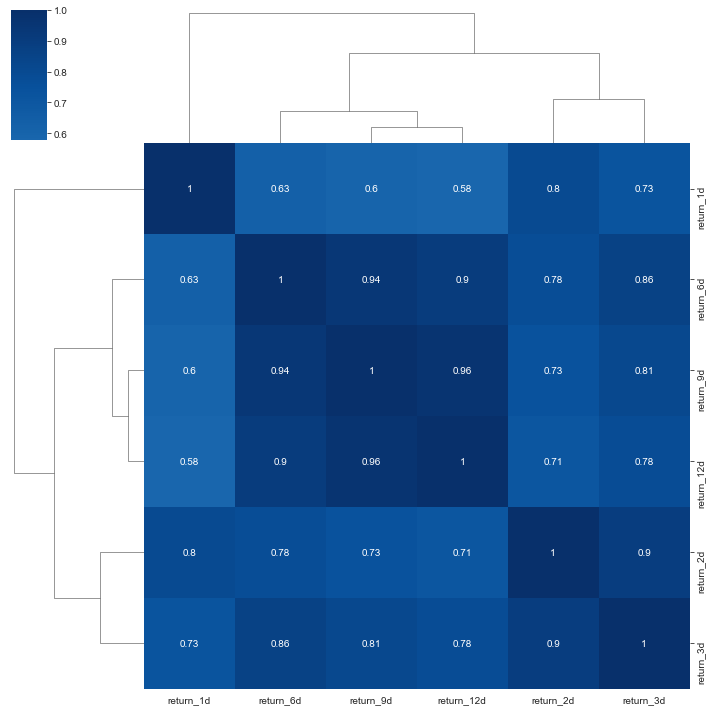

In [14]:
sns.clustermap(data_eng.corr('spearman'), annot=True, center=0, cmap='Blues');

## News Dataset:

In [15]:
news_link = pd.read_csv('Data/lithium_merged.csv')[["DATE", "DocumentIdentifier"]]
# transfer the date into correct format: 
news_link.DATE = news_link.DATE.apply(transform_date_news)
news_link.columns = ['date', 'url']
news_link.set_index('date')
news_link.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8313 entries, 0 to 8312
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    8313 non-null   object
 1   url     8313 non-null   object
dtypes: object(2)
memory usage: 130.0+ KB


In [16]:
news_link.describe()

,date,url
count,8313,8313
unique,2043,8311
top,2023-04-21,https://mrtopstep.com/peak-asset-morning-wrap-...
freq,60,2


In [17]:
news_link=news_link.set_index('date')
news_link.sort_index(inplace = True, ascending = False)

In [24]:
news_link_test = news_link.loc[(news_link.index >= '2020-05-01') & (news_link.index <= '2023-05-01')]
news_link_test["text"] = news_link_test.url.apply(get_clean_text)

In [28]:
news_link_test.describe()

,url,text
count,3765,3181
unique,3764,2827
top,https://mrtopstep.com/peak-asset-morning-wrap-...,
freq,2,103


In [ ]:
# news_link_test.to_csv()

### News - Price Modelling

Assume that news could have effect on prices in the following day, but the market still need several days to response. 

Issues: news might could be duplicate so that we need to remove "duplicate" news that covering the similar issues in continous days. 

#### Lithium Price 

Day-1, Day-2, Day-3, Day-6, Day-9, Day-12


#### News Data Set Engineering: 

1) Vectorize the text data

2) Cluster news based on the content similarity (giving a threshold);
https://datarefiner.com/feed/why-tda 

3) Push the news to the earliest day;

4) Create vocabulary to each day, vectorized using TD-IDF. 

**Using the vectors as features to build model (Random Forest, Linear Regression and etc.)**

## Vectorize for each article: 

Using TfidfVectorizer vectorize each article, and store data into h5ad files

In [ ]:
new_text 

In [38]:
news_link_test = news_link_test.reset_index()

# filter out None in text 
news_link_test_filtered  = news_link_test.loc[news_link_test['text'].notnull()]
X = news_link_test_filtered.text

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8, min_df=50/3181, ngram_range=(1,1)).fit(np.array(X))
X_vect = tfidf_vectorizer.transform(X)

NameError: name 'np' is not defined

In [67]:
df_obs = news_link_test_filtered[['date', 'url', 'text']].reset_index(drop = True)
adata_test = sc.AnnData(X_vect, obs = df_obs)

In [71]:
# adata_test.write('Data/adata_test.h5ad', compression="gzip")